In [3]:
import sys
import os
sys.path.append("/content/ml-project-2-pytyeee")
REPO_DIR = "ml-project-2-pytyeee/"

In [4]:
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader, TensorDataset
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from scripts.preprocessing import *
from helpers.model_handler import *

In [5]:
NUM_CPU = os.cpu_count() if os.cpu_count() is not None else 0
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE, NUM_CPU)

TRAINING_SIZE = 800
BATCH_SIZE = 32
NUM_EPOCHS = 30
BASE_LR = 0.0001

ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'

cuda 2


In [6]:
train_dir = REPO_DIR + "dataset/training/"
train_images_filename = train_dir + "augmented_images/"
train_masks_filename = train_dir + "augmented_groundtruth/"

train_images = extract_data(train_images_filename, TRAINING_SIZE)
train_masks = extract_data(train_masks_filename, TRAINING_SIZE)
print(f"Input shapes: {train_images.shape, train_masks.shape}")

Loading ml-project-2-pytyeee/dataset/training/augmented_images/satImage_001.png
Loading ml-project-2-pytyeee/dataset/training/augmented_images/satImage_800.png
Loading ml-project-2-pytyeee/dataset/training/augmented_groundtruth/satImage_001.png
Loading ml-project-2-pytyeee/dataset/training/augmented_groundtruth/satImage_800.png
Input shapes: ((800, 400, 400, 3), (800, 400, 400))


In [7]:
# Resize images to a size divisible by 32 to make it UNet compatible
train_data = img_resize(np.transpose(train_images, (0, 3, 1, 2)), (416, 416))
train_labels = img_resize(np.transpose(np.expand_dims(train_masks, -1), (0, 3, 1, 2)),  (416, 416))

# 1 hot encode each non black pixel to 1 pixel
train_labels[train_labels > 0] = 1
print(f"New shapes: {train_data.shape, train_labels.shape}")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


New shapes: (torch.Size([800, 3, 416, 416]), torch.Size([800, 1, 416, 416]))


In [11]:
train_data, val_data, train_labels, val_labels = split_data(train_data, train_labels, 0.7, seed=7)

Data split on ratio 0.7: TRAINING torch.Size([392, 3, 416, 416]) & torch.Size([392, 1, 416, 416]) and TEST torch.Size([168, 3, 416, 416]) & torch.Size([168, 1, 416, 416])


In [10]:
# Create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=1, # 1 for grayscale
    activation=ACTIVATION,
)

model = model.to(DEVICE)
# preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [12]:
VAL_SIZE = val_data.shape[0]
print(VAL_SIZE)

# Create datasets
train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)

# Get train data loader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_CPU)

168


In [13]:
# define loss
criterion = smp.losses.DiceLoss('binary')

# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=BASE_LR)

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

In [34]:
def train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device):
    # ***************************************************
    # Set model to training mode (affects dropout, batch norm e.g.)
    model.train()

    tr_loss_history = []
    tr_accuracy_history = []
    lr_history = []

    loss_history = []
    accuracy_history = []
    f1_score_history = []
    iou_score_history = []

    for batch_idx, (data, target) in enumerate(train_loader):
        # Move the data to the device
        data, target = data.to(device), target.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Compute model output
        output = model(data)
        # Compute loss
        tr_loss = criterion(output, target)
        # Backpropagate loss
        tr_loss.backward()
        # Perform an optimizer step
        optimizer.step()
        # Perform a learning rate scheduler step
        scheduler.step()
        # Compute accuracy_float (float value, not a tensor)
        tp, fp, fn, tn = smp.metrics.get_stats(val_output, val_target, mode='binary', threshold=0.5)
        tr_accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro").item()
        # Compute loss_float (float value, not a tensor)
        tr_loss_float = tr_loss.item()

        # Add validation loss, f1 and accuracy
        with torch.no_grad():
          val_data, val_target = val_dataset.tensors[0].to(device), val_dataset.tensors[1].to(device)
          val_output = model(val_data)

          tp, fp, fn, tn = smp.metrics.get_stats(val_output, val_target, mode='binary', threshold=0.5)

          loss = criterion(val_output, val_target).item()
          iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
          f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
          accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")

        print(
            f"Train Epoch: {epoch}-{batch_idx:03d} "
            f"batch_loss={tr_loss_float:0.2e} "
            f"batch_acc={tr_accuracy:0.3f} "
            f"lr={scheduler.get_last_lr()[0]:0.3e} "
            f"\nValidation: "
            f"loss={loss}"
            f"accuracy={accuracy}"
            f"iou_score={iou_score}"
            f"f1_score={f1_score}"
        )

        tr_loss_history.append(tr_loss_float)
        tr_accuracy_history.append(tr_accuracy)
        lr_history.append(scheduler.get_last_lr()[0])
        loss_history.append(loss)
        iou_score_history.append(iou_score)
        f1_score_history.apppend(f1_score)
        accuracy_history.append(accuracy)

    return loss_history, accuracy_history, lr_history, loss_history, accuracy_history, iou_score_history, f1_score_history, output, target

In [35]:
lrs = []
tr_losses = []
tr_accs = []
losses = []
ious = []
accs = []
f1s = []
for epoch in range(1, NUM_EPOCHS + 1):
    tr_loss, tr_acc, lr, acc, iou, f1, out, tar = train_epoch(
        model, optimizer, lr_scheduler, criterion, train_loader, epoch, DEVICE
    )
    tr_losses.extend(tr_loss)
    tr_accs.extend(tr_acc)
    lrs.extend(lr)
    accs.extend(acc)
    ious.extend[iou]
    f1s.extend(f1)


OutOfMemoryError: ignored

In [ ]:
print(len(train_loss_history), len(train_acc_history), len(lr_history))
print(NUM_EPOCHS * (TRAINING_SIZE // BATCH_SIZE + 1))

750 750 750
780


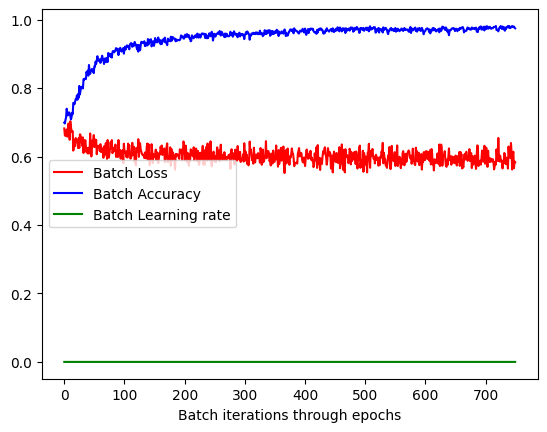

In [ ]:
train_acc_history_cpu = [t.cpu() for t in train_acc_history]

# Scatter plot
time_axis = np.arange(len(train_loss_history))
plt.plot(time_axis, train_loss_history, label='Batch Loss', color='red')
plt.plot(time_axis, train_acc_history_cpu, label='Batch Accuracy', color='blue')
plt.plot(time_axis, lr_history, label='Batch Learning rate', color='green')

plt.xlabel('Batch iterations through epochs')
plt.legend()
plt.show()

In [ ]:
save_model(model, REPO_DIR + "models/")

Model saved to ml-project-2-pytyeee/models/model_2023-12-12_0.pt
